In [2]:
import os
import sys
cwd = os.getcwd()
module_path = os.path.abspath(os.path.join('..'))
sys.path.insert(0, os.path.join(cwd, "../"))
import warnings
warnings.filterwarnings('ignore')

import pickle
import torch
import importlib
import numpy as np
import pandas as pd
import tqdm
from statistics import mean as list_mean
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

import src.bin.tensorify as tensorify
import src.utils.data_conversion_utils as conversions
import src.data_manager.student_life_var_binned_data_manager as data_manager
import src.bin.trainer as trainer
from src.bin.trainer import validate_key_set_str

from sklearn import metrics

from torch import nn
from copy import copy
from copy import deepcopy
from src import definitions
from src.bin import validations
from src.bin import statistics
from src.bin import plotting
from src.utils.read_utils import read_pickle
from src.utils import student_utils
from src.data_manager import sub_sampler
from src.data_manager import cross_val
from src.data_manager import helper as data_manager_helper
from tabulate import tabulate

from src.models.multitask_learning import multitask_autoencoder

pd.set_option('max_rows', 10000)

importlib.reload(multitask_autoencoder)
%load_ext autoreload
%autoreload 2
%matplotlib inline
feature_list = data_manager.FEATURE_LIST

In [3]:
# ##### Pickle #####
data = read_pickle('../data/training_data/shuffled_splits/training_date_normalized_shuffled_splits_select_features_no_prev_stress_2.pkl')
splits = cross_val.get_k_fod_cross_val_splits_stratified_by_students(data=data, n_splits=5)
print("Splits: ", len(splits))
for spl in splits:
    print(spl.keys(), len(spl['train_ids']) + len(spl['val_ids']))

############ Stats ############# 
# unnormalized_data = data_manager.get_data_for_training_in_dict_format(*student_list, normalize=False, fill_na=False)
# statistics_df, raw_df = statistics.get_statistics_on_data_dict(unnormalized_data, feature_list)
print(statistics.get_train_test_val_label_counts_from_raw_data(data))

student_label
Splits:  5
dict_keys(['train_ids', 'val_ids']) 545
dict_keys(['train_ids', 'val_ids']) 545
dict_keys(['train_ids', 'val_ids']) 545
dict_keys(['train_ids', 'val_ids']) 545
dict_keys(['train_ids', 'val_ids']) 545
      Train    Val    Test
--  -------  -----  ------
 0      105     53      27
 1      123     50      43
 2       99     27      18


In [4]:
################################## Init ##################################
use_historgram = True
autencoder_bottle_neck_feature_size = 128
autoencoder_num_layers = 1
alpha , beta = 0.0001, 1
decay = 0.0001
first_key = next(iter(data['data'].keys()))
if use_historgram:
    num_features = len(data['data'][first_key][4][0])
else:
    num_features = len(data['data'][first_key][0][0])
num_covariates = len(data['data'][first_key][definitions.COVARIATE_DATA_IDX])
shared_hidden_layer_size = 256
user_dense_layer_hidden_size = 64
num_classes = 3
learning_rate = 0.000001
n_epochs = 250
shared_layer_dropout_prob=0.00
user_head_dropout_prob=0.00

device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')

print("Num Features:", num_features)
print("Device: ", device)
print("Num_covariates:", num_covariates)


Num Features: 9
Device:  cuda
Num_covariates: 4


In [5]:
print(module_path)
data_path = "{}/data".format(module_path)
ae_model_path = "{}/best_ae_multi_task_model.tar".format(data_path)
print(ae_model_path, os.path.exists(ae_model_path))

/home/nsimsiri/MultiRes/student_life
/home/nsimsiri/MultiRes/student_life/data/best_ae_multi_task_model.tar True


In [6]:
cuda_enabled = torch.cuda.is_available()
tensorified_data = tensorify.tensorify_data_gru_d(deepcopy(data), cuda_enabled)
student_list = conversions.extract_distinct_student_idsfrom_keys(data['data'].keys())

In [7]:
def evaluate_multitask_learner(data,
                               key_set: str,
                               num_classes,
                               multitask_lerner_model,
                               reconstruction_criterion,
                               classification_criterion,
                               device,
                               optimizer=None,
                               alpha=1,
                               beta=1,
                               use_histogram=False,
                               histogram_seq_len=None,
                               ordinal_regression=False,
                               use_covariates=True):
    validations.validate_data_dict_keys(data)
    validate_key_set_str(key_set)
    
    labels = []
    predictions = []
    users = []
    autoencoder_output_list = []
    bottleneck_list = []
    s1, s2, s3, s4 = [],[],[],[]
    input_data = []

    multitask_lerner_model.eval()
    
    for key in data[key_set]:
        student_id = conversions.extract_student_id_from_key(key)
        student_key = 'student_' + str(student_id)
        actual_data, covariate_data, histogram_data, train_label = data['data'][key]
        
        actual_data = actual_data[0].unsqueeze(0)

        if use_histogram:
            if histogram_seq_len:
                histogram_data = histogram_data[:max(histogram_seq_len, len(histogram_data))]
            actual_data = histogram_data.unsqueeze(0)
        
        autoencoder_output, bottleneck,share1, share2, share3, share4 = \
            multitask_lerner_model(student_key, actual_data, covariate_data, plotting=True)
        autoencoder_output_list.append(autoencoder_output)
        bottleneck_list.append(bottleneck)
        labels.append(train_label)
        s1.append(share1)
        s2.append(share2)
        s3.append(share3)
        s4.append(share4)
        input_data.append(actual_data)
        users.append(student_id)


    return input_data, autoencoder_output_list, bottleneck_list, s1, s2, s3, s4, labels, predictions, users

In [8]:
from collections import defaultdict
plot_dict = defaultdict(list)
for split_no, split in enumerate(splits):
    print("Split No: ", split_no)
    
    best_split_score = -1
    epoch_at_best_score = 0
    
    tensorified_data['train_ids'] = split['train_ids']
    data['train_ids'] = split['train_ids']
    
    tensorified_data['val_ids'] = split['val_ids']
    data['val_ids'] = split['val_ids']
    
#     tensorified_data['test_ids'] = split['test_ids']
    print(split.keys())
#     data['test_ids'] = split['test_ids']
#     print(len(split['test_ids']))
        
    class_weights = torch.tensor(statistics.get_class_weights_in_inverse_proportion(data))
    class_weights = torch.tensor([0.93, 0.82, 1])
    model = multitask_autoencoder.MultiTaskAutoEncoderLearner(
                                   conversions.prepend_ids_with_string(student_list, "student_"),
                                   num_features,
                                   autencoder_bottle_neck_feature_size,
                                   autoencoder_num_layers,
                                   shared_hidden_layer_size,
                                   user_dense_layer_hidden_size,
                                   num_classes,
                                   num_covariates,
                                   shared_layer_dropout_prob,
                                   user_head_dropout_prob)
    state_dict = torch.load(ae_model_path)
    model.load_state_dict(state_dict)
    model.cuda()
    
    reconstruction_criterion = None
    classification_criterion =None
    
    input_data, autoencoder_output_list, bottleneck_list, share1, share2, share3, share4,labels,predictions, users = \
        evaluate_multitask_learner(tensorified_data, 
                              'train_ids',
                              num_classes,
                              model,
                              reconstruction_criterion ,
                              classification_criterion,
                              device,
                              optimizer=None,
                              alpha=alpha,
                              beta=beta,
                              use_histogram=use_historgram)
    
    plot_dict['bottleneck'] += bottleneck_list
    plot_dict['decoder'] += autoencoder_output_list
    plot_dict['labels'] += labels
    plot_dict['students'] += users
    plot_dict['share1'] += share1
    plot_dict['share2'] += share2
    plot_dict['share3'] += share3
    plot_dict['share4'] += share4
    plot_dict['input'] += input_data
    
    input_data, autoencoder_output_list, bottleneck_list, share1, share2, share3, share4, labels, predictions, users = \
        evaluate_multitask_learner(tensorified_data, 
                          'val_ids',
                          num_classes,
                          model,
                          reconstruction_criterion ,
                          classification_criterion,
                          device,
                          optimizer=None,
                          alpha=alpha,
                          beta=beta,
                          use_histogram=use_historgram)

    plot_dict['bottleneck'] += bottleneck_list
    plot_dict['decoder'] += autoencoder_output_list
    plot_dict['labels'] += labels
    plot_dict['students'] += users
    plot_dict['share1'] += share1
    plot_dict['share2'] += share2
    plot_dict['share3'] += share3
    plot_dict['share4'] += share4
    plot_dict['input'] += input_data
    
    print("\n====OK")
    
    break


Split No:  0
dict_keys(['train_ids', 'val_ids'])
## DEBUG ## - train_only_covariate (shold be false) False
## DEBUG ## - shared layer size 132

====OK


In [9]:
print(len(plot_dict['students']), len(plot_dict['labels']))
print(plot_dict['labels'][0])
print(plot_dict['bottleneck'][1].size())
print(plot_dict['decoder'][1].size())
print(len(plot_dict['input']))
print(plot_dict['input'][0].shape)

545 545
tensor([1], device='cuda:0')
torch.Size([1, 132])
torch.Size([1, 25, 9])
545
torch.Size([1, 25, 9])


In [10]:
# print(model)
embs = plot_dict['bottleneck']
print(len(embs))
print(embs[0].size())
print("")
ae_w = np.array([emb.detach().cpu().numpy().reshape((-1)) for emb in embs])
np_labels = np.array([lab.detach().cpu() for lab in plot_dict['labels']])
np_users = np.array([int(stud) for stud in plot_dict['students']])

print('labels', np_labels.shape)
print("studetns", np_users[:3])
print('ae_embed', ae_w.shape)

dim_0 = np.max([emb.shape[1] for emb in plot_dict['decoder']])
dim_1 = np.max([emb.shape[2] for emb in plot_dict['decoder']])
dec = [emb.detach().cpu().numpy() for emb in plot_dict['decoder']]
dec2 = np.array([np.resize(emb, (dim_0, dim_1)).reshape((-1)) for emb in dec])
print('dec', dec2.shape)

emb_s1 = np.array([emb.detach().cpu().numpy() for emb in plot_dict['share1']]).squeeze(1)
print(emb_s1.shape)

emb_s2 = np.array([emb.detach().cpu().numpy() for emb in plot_dict['share2']]).squeeze(1)
print(emb_s2.shape)

emb_s3 = np.array([emb.detach().cpu().numpy() for emb in plot_dict['share3']]).squeeze(1)
print(emb_s3.shape)

emb_s4 = np.array([emb.detach().cpu().numpy() for emb in plot_dict['share4']]).squeeze(1)
print(emb_s4.shape)


inp_0 = np.max([emb.shape[1] for emb in plot_dict['input']])
inp_1 = np.max([emb.shape[2] for emb in plot_dict['input']])
raw_input = [emb.detach().cpu().numpy() for emb in plot_dict['input']]
raw_input_2 = np.array([np.resize(emb, (inp_0, inp_1)).reshape((-1)) for emb in raw_input])
print('raw_input', raw_input_2.shape)

545
torch.Size([1, 132])

labels (545,)
studetns [1 1 1]
ae_embed (545, 132)
dec (545, 225)
(545, 256)
(545, 256)
(545, 128)
(545, 128)
raw_input (545, 225)


In [14]:
from collections import defaultdict
def tsne_result_to_xy(tsne_result):
    pass
def run_tsne(emb, labels):
    tmp = defaultdict(list)
    tmp2 = {}
    tmp3 = {}
    tsne = TSNE(n_components=2, perplexity=10, n_iter=300)
    emb = tsne.fit_transform(emb)
    
    for i,y in enumerate(labels):
        tmp[y].append(emb[i])
    
    for k,v in tmp.items():
        tmp2[k] = np.array(v)
#     tsne = TSNE(n_components=2, perplexity=10, n_iter=300)
#     for k,v in tmp2.items():
#         tsne_result = tsne.fit_transform(v)
#         tmp3[k] = tsne_result
    return tmp2

# stress_map = run_tsne(ae_w, np_labels)
stress_map_dec = run_tsne(dec2, np_labels)
stress_map_s1 = run_tsne(emb_s1, np_labels)
stress_map_s2 = run_tsne(emb_s2, np_labels)
stress_map_s3 = run_tsne(emb_s3, np_labels)
stress_map_s4 = run_tsne(emb_s4, np_labels)
        

In [35]:
# def run_tsne_stud(emb, np_users):
#     tmp = defaultdict(list)
#     tmp2 = {}
#     tmp3 = {}
#     stud = set(np_users.tolist())
#     print(stud, len(stud))
#     for i,u in enumerate(np_users):
#         tmp[u].append(emb[i])
#     for k,v in tmp.items():
#         tmp2[k] = np.array(v)
#     tsne = TSNE(n_components=2, perplexity=10, n_iter=300)
#     for k,v in tmp2.items():
#         tsne_result = tsne.fit_transform(v)
#         tmp3[k] = tsne_result
#     return tmp3
        
def run_tsne_stud(emb, np_users):
    tmp = defaultdict(list)
    tmp2 = {}
    tmp3 = {}
    stud = set(np_users.tolist())
    print(stud, len(stud))
    print(emb.shape)
    tsne = TSNE(n_components=2, perplexity=10, n_iter=300)
    emb = tsne.fit_transform(emb)
    print(emb.shape)
    for i,u in enumerate(np_users):
        tmp[u].append(emb[i])
    for k,v in tmp.items():
        tmp2[k] = np.array(v)
#     for k,v in tmp2.items():
#         tsne_result = tsne.fit_transform(v)
#         tmp3[k] = tsne_result
    return tmp2
    
share_l0_per_stud = run_tsne_stud(emb_s2, np_users)
share_l1_per_stud = run_tsne_stud(emb_s4, np_users)
input_tsne_per_stud = run_tsne_stud(emb_s4, np_users)
dec_output_tsne_per_stud = run_tsne_stud(dec2, np_users)
enc_output_tsne_per_stud = run_tsne_stud(ae_w, np_users)

{1, 2, 33, 4, 7, 10, 42, 46, 49, 53, 22, 24, 57} 13
(545, 256)
(545, 2)
{1, 2, 33, 4, 7, 10, 42, 46, 49, 53, 22, 24, 57} 13
(545, 128)
(545, 2)
{1, 2, 33, 4, 7, 10, 42, 46, 49, 53, 22, 24, 57} 13
(545, 128)
(545, 2)
{1, 2, 33, 4, 7, 10, 42, 46, 49, 53, 22, 24, 57} 13
(545, 225)
(545, 2)
{1, 2, 33, 4, 7, 10, 42, 46, 49, 53, 22, 24, 57} 13
(545, 132)
(545, 2)


(185, 2)
(216, 2)
(144, 2)
(185, 2)
(216, 2)
(144, 2)
(185, 2)
(216, 2)
(144, 2)
(185, 2)
(216, 2)
(144, 2)
(185, 2)
(216, 2)
(144, 2)


<Figure size 432x288 with 0 Axes>

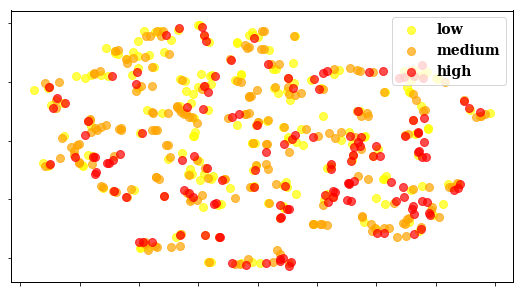

<Figure size 432x288 with 0 Axes>

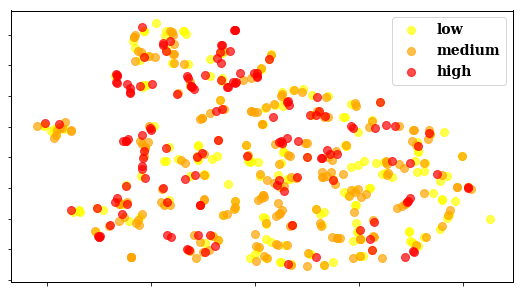

<Figure size 432x288 with 0 Axes>

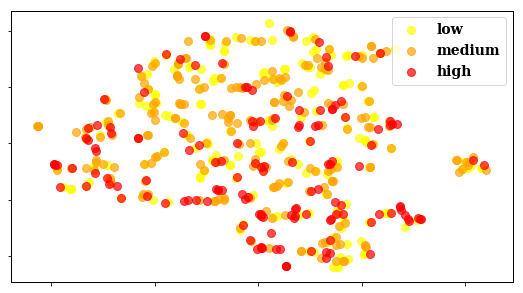

<Figure size 432x288 with 0 Axes>

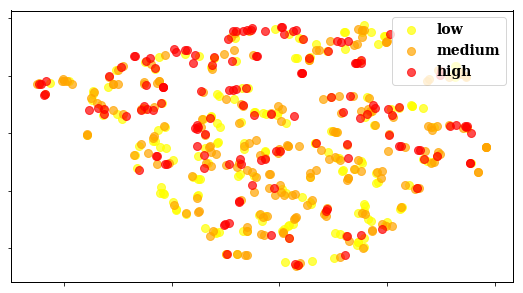

<Figure size 432x288 with 0 Axes>

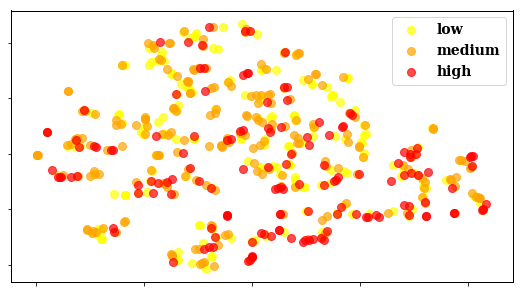

In [15]:
def plot_tsne_stress(stress_map, title):
    f = plt.figure()
    plt.rc('font', weight='bold', size='12', family='serif')
    plt.rc('axes', linewidth=1)
    plt.rc('lines',linewidth=1,markersize=8)
    matplotlib.use('PDF')
    fig,ax =  plt.subplots(figsize=(9,5))
    groups = ['low', 'medium', 'high']
    stress_keys = sorted(list(stress_map.keys()))
    for i, stress_key  in enumerate(stress_keys):
        tsne_xy = stress_map[stress_key]
        print(tsne_xy.shape)
        X = tsne_xy[:,0]
        y = tsne_xy[:,1]
        cmap = matplotlib.cm.get_cmap('prism')
        ax.scatter(X,y, color=['yellow','orange','red'][i], alpha = 0.7, label=groups[i])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
#     plt.title(title)
    plt.legend(loc='upper right', prop={'size': 14})
    plt.show()
    fname="{}/plots/{}.pdf".format(data_path, title)
#     print(fname)
    fig.savefig(fname, dpi=1000)

# plot_tsne_stress(stress_map, 't-SNE Autoencoder Bottleneck with Stress')
plot_tsne_stress(stress_map_dec, 't-SNE Autoencoder Output with Stress')
plot_tsne_stress(stress_map_s1, 't-SNE Shared-1 Output with Stress')
plot_tsne_stress(stress_map_s2, 't-SNE Shared-1-act with Stress')
plot_tsne_stress(stress_map_s3, 't-SNE Shared-2 Output with Stress')
plot_tsne_stress(stress_map_s4, 't-SNE Shared-2-act Output with Stress')

[1, 2, 4, 7, 10, 22, 24, 33, 42, 46, 49, 53, 57]
/home/nsimsiri/MultiRes/student_life/data/plots/t-SNE Shared Layer 0 output per student.pdf
[1, 2, 4, 7, 10, 22, 24, 33, 42, 46, 49, 53, 57]
/home/nsimsiri/MultiRes/student_life/data/plots/t-SNE Shared Layer 1 output per student.pdf
[1, 2, 4, 7, 10, 22, 24, 33, 42, 46, 49, 53, 57]
/home/nsimsiri/MultiRes/student_life/data/plots/t-SNE Input Data per student.pdf
[1, 2, 4, 7, 10, 22, 24, 33, 42, 46, 49, 53, 57]
/home/nsimsiri/MultiRes/student_life/data/plots/t-SNE Autoencoder Bottleneck per student.pdf


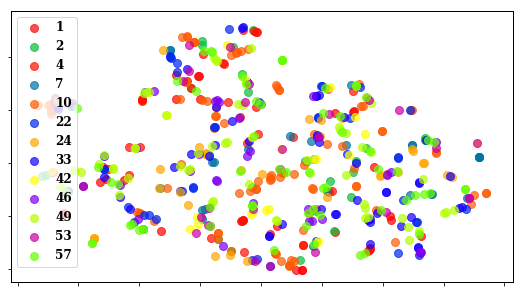

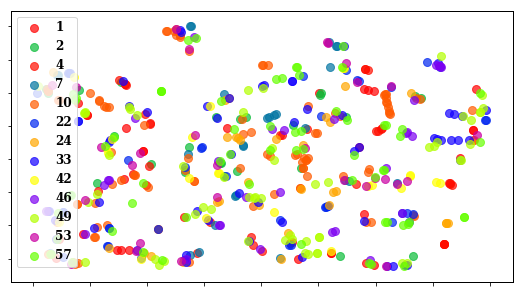

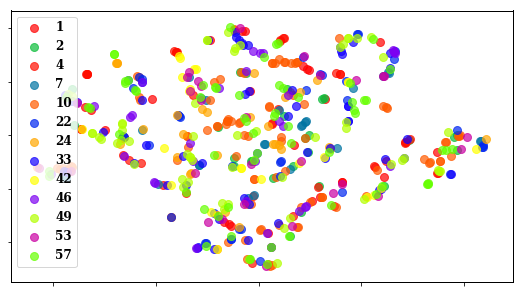

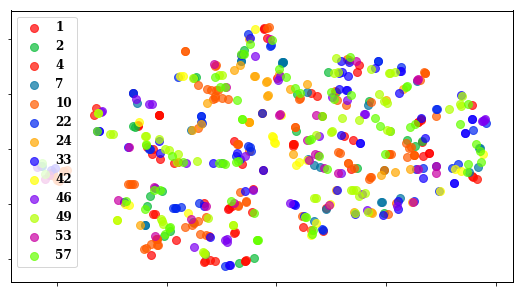

In [36]:
def plot_tsne_user_map(user_map, title):
    stud_set = list(user_map.keys())
    print(stud_set)
    plt.rc('font', weight='bold', size='12', family='serif')
    plt.rc('axes', linewidth=1)
    plt.rc('lines',linewidth=1,markersize=8)
    matplotlib.use('PDF')
    fig,ax =  plt.subplots(figsize=(9,5))
    groups = stud_set
    user_ids = sorted(list(user_map.keys()))
    for i, user_id  in enumerate(user_ids):
        tsne_xy = user_map[user_id]
        X = tsne_xy[:,0]
        y = tsne_xy[:,1]
        cmap = matplotlib.cm.get_cmap('prism')
        ax.scatter(X,y, color=cmap((2*i)/39), alpha = 0.7, label=groups[i])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
#     plt.title(title)
    plt.legend(loc='upper left', prop={'size': 12
                                      })
    plt.show()
    fname="{}/plots/{}.pdf".format(data_path, title)
    print(fname)
    fig.savefig(fname,dpi=1000)

plot_tsne_user_map(share_l0_per_stud, "t-SNE Shared Layer 0 output per student")
plot_tsne_user_map(share_l1_per_stud, "t-SNE Shared Layer 1 output per student")
plot_tsne_user_map(input_tsne_per_stud, "t-SNE Input Data per student")
plot_tsne_user_map(enc_output_tsne_per_stud, "t-SNE Autoencoder Bottleneck per student")

In [ ]:
test = nn.LSTM(input_size=9, hidden_size=128, batch_first=True)
print(test)

h,c = test(torch.randn((5,10,9)))
print(h.size())

In [ ]:
print(model)